### Homework 4

<b> Problem 1: Quantum Fourier Transform </b>
Design the quantum circuit which implements QFT for $n=2$ and $n=3$ Qbits and
test it using qiskit.  


 <br />
<br />
  
<b> Solution </b>

By definition the QFT is the following unitary operation

 $QFT|x\rangle = \frac{1}{2^{n/2}}\sum_{y=0}^{2^n-1}e^{2\pi i \frac{xy}{2^n}} |y\rangle$

Note that here $xy$ is a usual multiplication. Let's unwrap this expression to understand how it can be implemeted in the real circuit. First let's represent $y$  in binary, i.e. $y=y_1 y_2 \dots y_n$ where $y_j$ are either 0 or 1, so

 $y = \sum\limits_{k=1}^{n} 2^{n-k} y_k$

Thus

 $\frac{1}{2^{n/2}}\sum_{y=0}^{2^n-1}e^{2\pi i \frac{xy}{2^n}} |y\rangle = 
 \frac{1}{2^{n/2}}\sum_{y=0}^{2^n-1}e^{2\pi ix \left[ \sum\limits_{k=1}^{n} y_k / 2^k \right]} 
 |y_1 y_2 \dots y_n\rangle  = 
 \frac{1}{2^{n/2}}\sum_{y=0}^{2^n-1}\prod\limits_{k=1}^{n}e^{2\pi ix y_k / 2^k } |y_1 y_2 \dots y_n\rangle = \\ =
 \frac{1}{2^{n/2}}\prod_{k=1}^{n}\left( e^{2\pi ix 0 / 2^k } |0\rangle_k + e^{2\pi ix 1 / 2^k } |1\rangle_k \right)= 
 \frac{1}{2^{n/2}}\prod\limits_{k=1}^{n}\left( |0\rangle_k + e^{2\pi ix / 2^k } |1\rangle_k \right)= \\ =
 \frac{1}{2^{n/2}} \left( |0\rangle_1 + e^{2\pi ix / 2 } |1\rangle_1  \right) \otimes 
 \left( |0\rangle_2 + e^{2\pi ix / 2^2 }  |1\rangle_2  \right) \otimes 
 \dots \otimes
 \left( |0\rangle_{n-1} + e^{2\pi ix / 2^{n-1} } |1\rangle_{n-1}  \right) 
 \otimes \left( |0\rangle_n + e^{2\pi ix / 2^n } |1\rangle_n  \right)$

We can see that we can construct such a state using single Q-bit gates

 $H|x_k\rangle = \frac{1}{\sqrt{2}}\left( |0\rangle + (-1)^{x_k}|1\rangle \right) \equiv \frac{1}{\sqrt{2}}
 \left( |0\rangle + e^{2\pi i x_k / 2}|1\rangle \right)$

This is already almost what we want

But we need a phase before the $|1\rangle_k$ state to be equal to $2\pi i x/2^k$. So we have to perform several additional rotations around the $z$-axis

Let's examine the following state

 $\prod\limits_{j=k+1}^{n} C_j ROT_k H |x\rangle_k$

where $C_j ROT_k$ is the controled rotation of the Q-bit $k$ around the $z$ axis on the angle $2\pi/2^k$ with the control Q-bit $j$. We can explicitly rewrite $C_j ROT_k$ in the following form

 $C_j ROT_k |1\rangle_k = e^{2\pi i x_j/2^k} |1\rangle_k$

Which basically means that we add phase $2\pi x_j/2^k$ if the control Q-bit $x_j=1$. 

Noting again that $x/2^n = \sum\limits_{j=1}^{n} x_j / 2^j$

 $\prod\limits_{j=k+1}^{n} C_j ROT_k H |x\rangle_k = \frac{1}{\sqrt{2}} \left( |0\rangle_k + e^{2\pi i \sum\limits_{j=k}^{n}  x_j / 2^j} |1\rangle_k\right) = \frac{1}{\sqrt{2}} \left( |0\rangle_k + e^{2\pi i x / 2^{(n-k)}} |1\rangle_k\right)$

So we get what we wanted, but the Q-bit numbers should be reversed after all the gates, i.e $k \rightarrow n-k$

Qiskit implemetation of QFT

In [3]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
import numpy as np
import numpy.random as rand

backend = Aer.get_backend('qasm_simulator')

In [4]:
def qft(qc, n):
    # Hadamards and rotations
    for i in range(n):
        qb = n - i - 1
        qc.h(qb)
        for j in range(n - i - 1):
            qc.cu1(np.pi/np.power(2, j + 1), qb - j - 1, qb)
        qc.barrier()
    
    # Indecies reversal
    for qb in range(n//2):
        qc.swap(qb, n - qb - 1)

Testing for $n = 3$

In [3]:
n = 3
l = np.power(2, n)
# Generating random initial state
init = (rand.rand(2 * l).astype(np.complex) - 0.5) * 2
init /= np.linalg.norm(init)
init = init.reshape(l, 2)
init[:,1] *= 1j
init = init[:,0] + init[:,1]
init

array([ 0.16386051+0.01186203j,  0.1506981 +0.19828995j,
        0.36195154-0.10964399j, -0.33471177+0.01902266j,
        0.38178857-0.26966034j, -0.30890114-0.01981044j,
        0.4073751 +0.11649737j, -0.05218693+0.39876622j])

In [4]:
# Manually calculating the QFT of the inital state
est = np.arange(l).astype(np.complex)
for i, y in enumerate(est):
    amp = np.zeros_like(init).astype(np.complex)
    for j, x in enumerate(init):
        amp[j] = np.exp(2 * np.pi * 1j * i * j / l) * x
    est[i] = 1 / np.sqrt(l) * np.sum(amp)
est

array([ 0.27219155+0.12209028j,  0.22884565+0.27720313j,
        0.00552668-0.01271238j, -0.30212248+0.01040046j,
        0.65763669-0.29953514j, -0.22303797-0.11025605j,
       -0.16369059-0.17442463j, -0.01188202+0.22078523j])

Visualize the cirquits

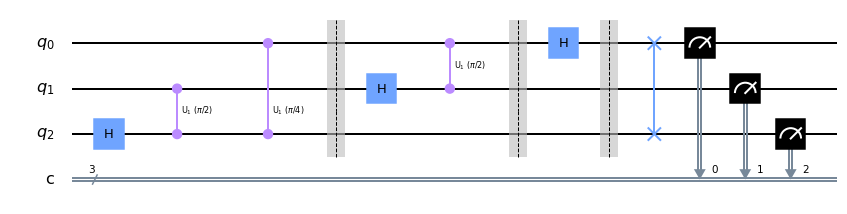

In [6]:
n=3
qc1 = QuantumCircuit(n, n)
#qc1.initialize(init, range(n))
qft(qc1, n)
qc1.measure(range(n), range(n));
qc1.draw(output='mpl',justify='none')

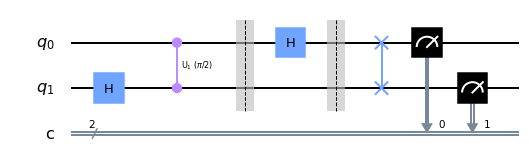

In [7]:
n=2
qc1 = QuantumCircuit(n, n)
#qc1.initialize(init, range(n))
qft(qc1, n)
qc1.measure(range(n), range(n));
qc1.draw(output='mpl',justify='none')

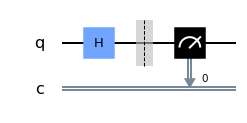

In [8]:
n=1
qc1 = QuantumCircuit(n, n)
#qc1.initialize(init, range(n))
qft(qc1, n)
qc1.measure(range(n), range(n));
qc1.draw(output='mpl',justify='none')

In [ ]:
qc = QuantumCircuit(n, n)
qc.initialize(init, range(n))
qft(qc, n)
qc.measure(range(n), range(n));

In [199]:
shots = 1024
res = execute(qc,backend,shots=shots).result()
res = np.array([[int(key, 2), val/shots] for key, val in res.get_counts().items()])

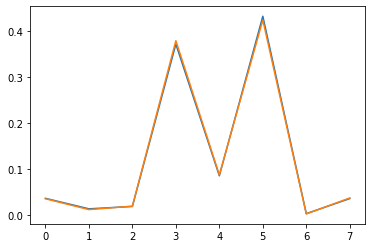

In [200]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(res[np.argsort(res[:,0]),1])
ax.plot(np.arange(l),np.abs(est)**2);

The plots coincide, thus our circuit indeed perofrm QFT

<b> Problem 2: Shor' algorith in qiskit </b>

 Design the quantum circuit which can find periods for the modular exponent $a^x (mod N)$ with some small number $a$ and $N$, e.g. $a=3$, $N=10$ or $a=2$, $N=9$. Test the algorithm using qiskit.
 
 <br />

  
<b> Solution </b>
We will use similar approach as in Qiskit tutorial. The key components is the realization of modular exponent $a^x (mod N)$ using qunatum operators. 


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import matplotlib.pyplot as plt 


Let's investigate the period $a^r mod N =1$ analytically

Could not find period, check a < N and have no common factors.


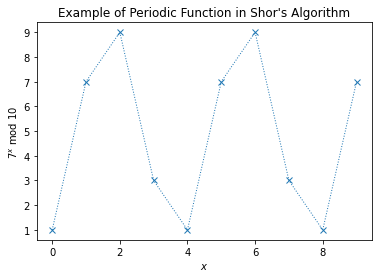

In [62]:
N = 10
a = 7

# Calculate the plotting data
xvals = np.arange(10)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

Inverse QFT

In [26]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

The realization of quantum modular multiplication $U_a |y\rangle =  |ay mod N \rangle $ for $y< N$ can be non-trivial in general. We will use the simplified approach based on the fact that the input state to which we apply operators  is $|1\rangle$. Then using e.g. $a=3$ and $N=10$ and $2^5 =32$ in the quantum phase estimation algorithm we note that   $U_a^4 |1\rangle =  |81 mod N \rangle = |1 mod N \rangle $ can be replaced by the identity operator. Next, $U_a^2 |1\rangle= |9 mod N \rangle = |1001 \rangle$ applied to state $|1\rangle$  acts $X_3$. 
Last, for the possible inputs $U_3 1 =3$ and $U_a 9 = |7\rangle$. In binary representation $U_3 0001 = 0011 $,  $U_3 1001 = 0111 $. One can see that such transformation is the same as $Swap(2,1) X_1$. Note that in contrast to the original oparators for $U_a^k$  such reduced operators don't commute so that their order is important.   

In [39]:
def U4():
    """Controlled multiplication by 81 mod 10"""
    U = QuantumCircuit(4)   
    U = U.to_gate()
    U.name = "U4" 
    c_U = U.control()
    return c_U

In [40]:
def U2():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(3)
    U = U.to_gate()
    U.name = "U2" 
    c_U = U.control()
    return c_U

In [41]:
def U1():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(1)
    U.swap(3,2)
    U = U.to_gate()
    U.name = "U1" 
    c_U = U.control()
    return c_U

In [53]:
# Create QuantumCircuit with n_count=3 counting qubits
# plus 4 qubits for U to act on
n_count=3;
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
#    if q==1: 
#        qc.append(U4(), 
#                 [q] + [i+n_count for i in range(4)])
    if q==1: 
        qc.append(U2(), 
                 [q] + [i+n_count for i in range(4)])
    if q==2: 
        qc.append(U1(), 
                 [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('text')

┌───┐              ┌───────┐┌─┐      
q_0: ┤ H ├──────────────┤0      ├┤M├──────
     ├───┤              │       │└╥┘┌─┐   
q_1: ┤ H ├───■──────────┤1 QFT† ├─╫─┤M├───
     ├───┤   │          │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───┼──────■───┤2      ├─╫──╫─┤M├
     └───┘┌─┴┼──┐┌─┴┼──┐└───────┘ ║  ║ └╥┘
q_3: ─────┤0 │  ├┤0 │  ├──────────╫──╫──╫─
          │     ││     │          ║  ║  ║ 
q_4: ─────┤1    ├┤1    ├──────────╫──╫──╫─
          │  U2 ││  U1 │          ║  ║  ║ 
q_5: ─────┤2    ├┤2    ├──────────╫──╫──╫─
     ┌───┐│     ││     │          ║  ║  ║ 
q_6: ┤ X ├┤3    ├┤3    ├──────────╫──╫──╫─
     └───┘└─────┘└─────┘          ║  ║  ║ 
c: 3/═════════════════════════════╩══╩══╩═
                                  0  1  2

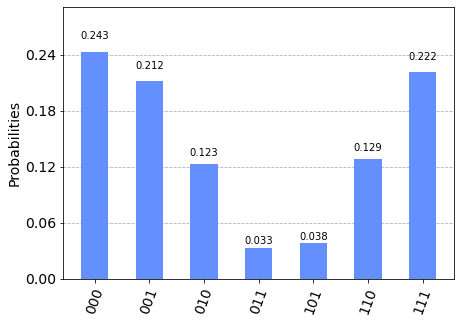

In [54]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Now, post-process these results using the code from qiskit tutorial for the calculation of $r$ using continous fraction expansion 

In [55]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

     Register Output       Phase
0  000(bin) = 0(dec)  0/8 = 0.00
1  001(bin) = 1(dec)  1/8 = 0.12
2  010(bin) = 2(dec)  2/8 = 0.25
3  011(bin) = 3(dec)  3/8 = 0.38
4  101(bin) = 5(dec)  5/8 = 0.62
5  110(bin) = 6(dec)  6/8 = 0.75
6  111(bin) = 7(dec)  7/8 = 0.88


In [57]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.625      5/8            8
5  0.750      3/4            4
6  0.875      7/8            8


Comparing with the above plot one can see that the procedure works. 